In [295]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

import itertools

import os
from pathlib import Path

#get my written functions
from userfuncs import prepare_dataframe, find_borders_nan_intervals, count_frequency, count_missing
from userfuncs import get_best_distribution, distribution_by_season, get_metrics

import warnings
warnings.filterwarnings("ignore")

#algorithms
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
#LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

#scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [296]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

In [297]:
from matplotlib import style
style.use('fivethirtyeight')

In [324]:
path_to_data = Path('../../data')
df = pd.read_csv(path_to_data / 'prepared_data_prioksk.csv')
test_data = pd.read_csv(path_to_data / 'data_prioksk_test.csv')
ELEMENTS = df.columns
df.head(2)

,TSP,SO2,PB,CD
0,9.0,0.02,21.0,0.54
1,5.0,0.03,20.0,0.53


In [325]:
IS_NORM = False

In [326]:
def plot_prediction(y_test, pred_test, target_name, y_train=None, pred_train=None):
    fontsize = 13
    lw = 1.5
    if y_train is not None and pred_train is not None:
        #train and test plot
        plt.figure(figsize=(10, 5))
        plt.title(f"{target_name} prediction", fontsize=fontsize)
        plt.plot(np.hstack([y_train.values, y_test.values]), lw=lw, label='actual')
        plt.plot(range(len(y_train)), pred_train, c='red', lw=lw, label='prediction')
        plt.plot(range(len(y_train), len(y_train) + len(y_test)), pred_test, lw=lw, c='red', label='prediction')
        plt.vlines(len(y_train), min(y_train), max(max(y_train), max(y_test))
           , ls='--', label='left train / right test')
#        plt.xlabel('Observation')
#        plt.ylabel('Quantity')
        plt.legend(loc='best', fontsize=fontsize)
        plt.grid(True)
    else:
        #test plot      
        plt.figure(figsize=(10, 5))
        plt.title(f"{target_name} prediction", fontsize=fontsize)
        lw=2
        plt.plot(y_test.values, label='actual', lw=lw)
        plt.plot(pred_test, c='red', label='prediction', lw=lw)
        #plt.xlabel('Observation')
        #plt.ylabel('Quantity')
        plt.legend(fontsize=fontsize)
        plt.grid(True)

In [327]:
def create_dataset(data, n_steps=1):
    '''Preparation data for LSTM model
    
    Parameters:
        data - numpy array
        n_steps - number of previous time steps to use as input variables to predict the next time period 
        
    Return:
        prepared data in a view X array and Y array
    '''
    
    X, y = [], []
    
    for i in range(len(data)-n_steps):
        a = data[i:i+n_steps]
        X.append(a)
        y.append(data[i + n_steps])
        
    return np.array(X), np.array(y)

def split_by_oredr(ts, test_size=0.2):
    
    
    return ts[:test_index].values.reshape(-1, 1), ts[test_index:].values.reshape(-1, 1)

In [328]:
def predict_by_lstm(train, test, n_steps=1, n_features=1, is_return_param=False):
    #since lstm is sensitive to the scale, need to to transform
    scaler = MinMaxScaler() #better than StandardScaler
    train_sc = scaler.fit_transform(train)
    test_sc = scaler.transform(test)

#    n_steps = 1
    Xtrain, ytrain = create_dataset(train_sc, n_steps)
    Xtest, ytest = create_dataset(test_sc, n_steps)

#    n_features = 1
    Xtrain = Xtrain.reshape(Xtrain.shape[0], n_steps, n_features)
    Xtest = Xtest.reshape(Xtest.shape[0], n_steps, n_features)

    np.random.seed(42)

    model_lstm = Sequential()
    opt = Adam(learning_rate=0.001)

    #LSTM
    model_lstm.add(Bidirectional(LSTM(20, activation='relu', return_sequences=True
                        , input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
    model_lstm.add(Bidirectional(LSTM(5, activation='relu')))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer=opt, loss='mse')
    
    history = model_lstm.fit(Xtrain, ytrain, epochs=180, batch_size=32, shuffle=False, use_multiprocessing=True
                   , validation_data=(Xtest, ytest), verbose=0)

    yhat_train_lstm = model_lstm.predict(Xtrain)
    yhat_test_lstm = model_lstm.predict(Xtest)
    #inverse to got true values
    yhat_train_lstm = scaler.inverse_transform(yhat_train_lstm)
    yhat_test_lstm = scaler.inverse_transform(yhat_test_lstm)
    yhat_train_lstm = yhat_train_lstm.squeeze()
    yhat_test_lstm = yhat_test_lstm.squeeze()
    
    
    if is_return_param:
        return yhat_train_lstm, yhat_test_lstm, model_lstm, scaler
    else:
        return yhat_train_lstm, yhat_test_lstm

def predict(num_prediction, model, data, n_steps, scaler):
    prediction_list = data[-n_steps:]
    
    prediction_list = scaler.transform(prediction_list.reshape(-1,1))
    for _ in range(num_prediction):
        x = prediction_list[-n_steps:]
        x = x.reshape((1, n_steps, 1)) #for n_features=1
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_steps-1:]
        
    return scaler.inverse_transform(prediction_list.reshape(-1,1))

### TSP

In [304]:
target_name = 'TSP'
test_size = 0.2
ts = df[target_name]
test_index = int(len(ts)*(1-test_size))
train, test = ts[:test_index].values.reshape(-1, 1), ts[test_index:].values.reshape(-1, 1)

In [305]:
n_steps = 1 #how many previous points to use to forecast the next one!
n_features = 1
pred_train, pred_test = predict_by_lstm(train, test, n_steps, n_features)

In [306]:
print('\t\t\t\t\t', target_name.upper())
print('\t\t\t  TRAIN')
for k, v in get_metrics(ts[:test_index-n_steps], pred_train, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')
print()
print('\t\t\t  TEST')
for k, v in get_metrics(ts[test_index+n_steps:], pred_test, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')

print('\n\n')

					 TSP
			  TRAIN
RMSE: 11.449142035329746  	MAE: 6.049896856834149   	
			  TEST
RMSE: 18.166202608678187  	MAE: 12.960141286580914  	




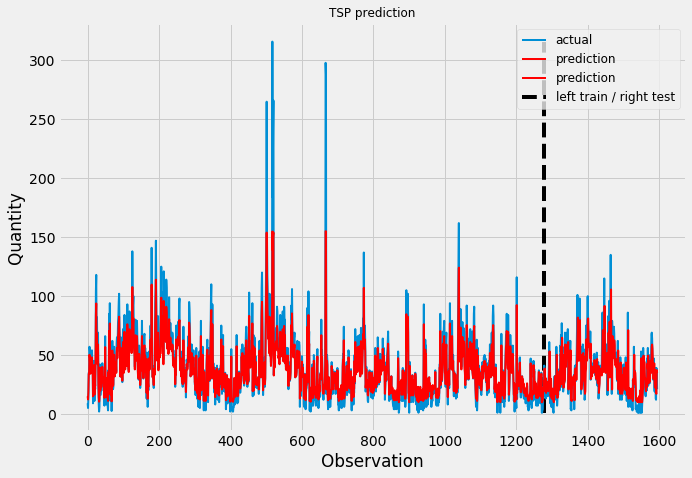

In [307]:
#train
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name
                , y_train=ts[:test_index-n_steps], pred_train=pred_train)

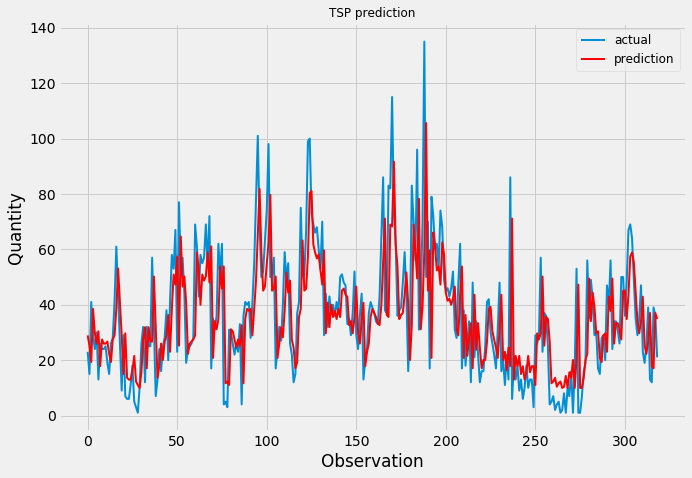

In [308]:
#test
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name)

### SO2

In [309]:
target_name = 'SO2'
test_size = 0.2
ts = df[target_name]
test_index = int(len(ts)*(1-test_size))
train, test = ts[:test_index].values.reshape(-1, 1), ts[test_index:].values.reshape(-1, 1)

In [310]:
n_steps = 3 #how many previous points to use to forecast the next one!
n_features = 1
pred_train, pred_test = predict_by_lstm(train, test, n_steps, n_features)

In [311]:
print('\t\t\t\t\t', target_name.upper())
print('\t\t\t  TRAIN')
for k, v in get_metrics(ts[:test_index-n_steps], pred_train, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')
print()
print('\t\t\t  TEST')
for k, v in get_metrics(ts[test_index+n_steps:], pred_test, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')

print('\n\n')

					 SO2
			  TRAIN
RMSE: 3.192043678122844   	MAE: 1.6557202043198294  	
			  TEST
RMSE: 2.125869828233653   	MAE: 1.1749066685915754  	




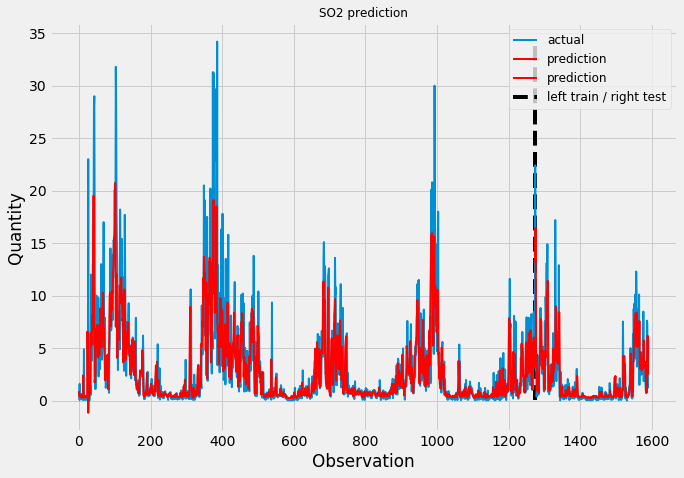

In [312]:
#train
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name
                , y_train=ts[:test_index-n_steps], pred_train=pred_train)

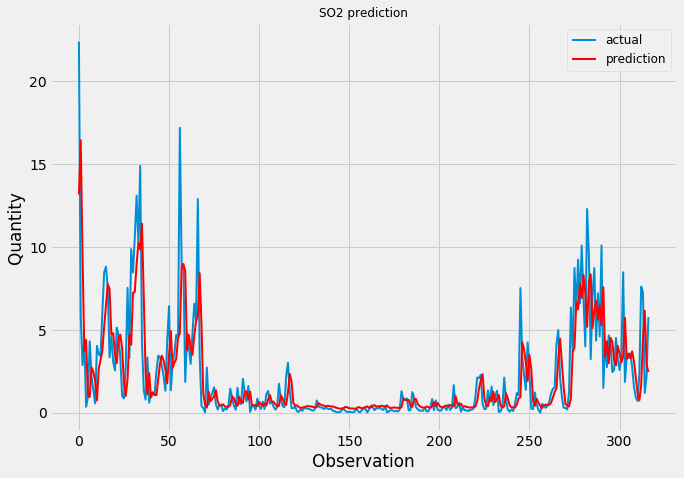

In [313]:
#test
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name)

### PB

In [314]:
target_name = 'PB'
test_size = 0.2
ts = df[target_name]
test_index = int(len(ts)*(1-test_size))
train, test = ts[:test_index].values.reshape(-1, 1), ts[test_index:].values.reshape(-1, 1)

In [315]:
n_steps = 7 #how many previous points to use to forecast the next one!
n_features = 1
pred_train, pred_test, model, scaler = predict_by_lstm(train, test, n_steps, n_features, True)

In [316]:
print('\t\t\t\t\t', target_name.upper())
print('\t\t\t  TRAIN')
for k, v in get_metrics(ts[:test_index-n_steps], pred_train, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')
print()
print('\t\t\t  TEST')
for k, v in get_metrics(ts[test_index+n_steps:], pred_test, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')

print('\n\n')

					 PB
			  TRAIN
RMSE: 7.476446073056309   	MAE: 5.241466410546789   	
			  TEST
RMSE: 4.1365069187181795  	MAE: 3.1056216604945748  	




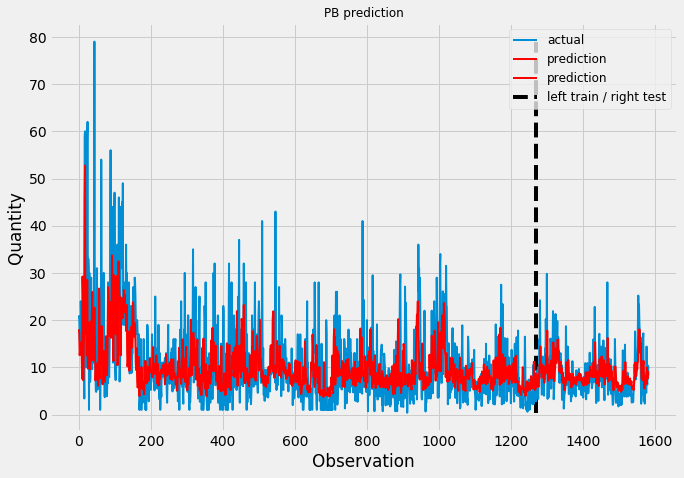

In [317]:
#train
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name
                , y_train=ts[:test_index-n_steps], pred_train=pred_train)

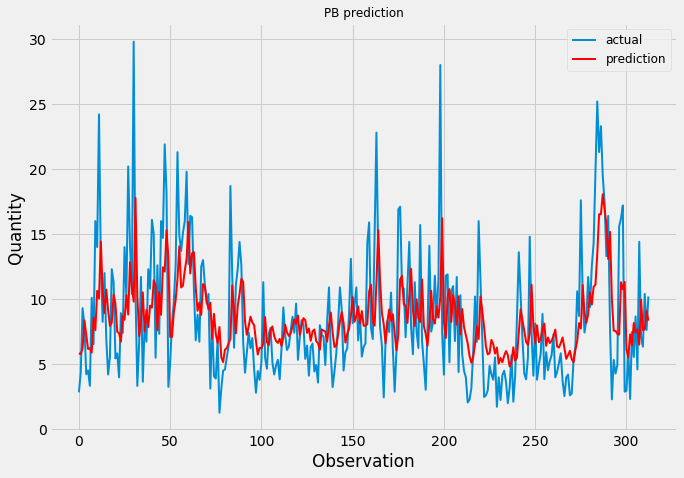

In [318]:
#test
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name)

In [284]:
#forecasting = predict(10, model, df[target_name].values, 7, scaler)
#надо переобучить на train+test, а потом предсказывать
#plot_prediction(y_test=test_data[target_name][:10], pred_test=forecasting, target_name=target_name)

### CD

In [329]:
target_name = 'CD'
test_size = 0.2
ts = df[target_name]
test_index = int(len(ts)*(1-test_size))
train, test = ts[:test_index].values.reshape(-1, 1), ts[test_index:].values.reshape(-1, 1)

In [330]:
n_steps = 7 #how many previous points to use to forecast the next one!
n_features = 1
pred_train, pred_test = predict_by_lstm(train, test, n_steps, n_features)

In [331]:
print('\t\t\t\t\t', target_name.upper())
print('\t\t\t  TRAIN')
for k, v in get_metrics(ts[:test_index-n_steps], pred_train, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')
print()
print('\t\t\t  TEST')
for k, v in get_metrics(ts[test_index+n_steps:], pred_test, metrics=['rmse', 'mae'], is_norm=IS_NORM).items():
    print(f"{k}: {v:<20}", end='\t')

print('\n\n')

					 CD
			  TRAIN
RMSE: 0.22559597413065652 	MAE: 0.14117251845205672 	
			  TEST
RMSE: 0.14313715964225493 	MAE: 0.09538265647509743 	




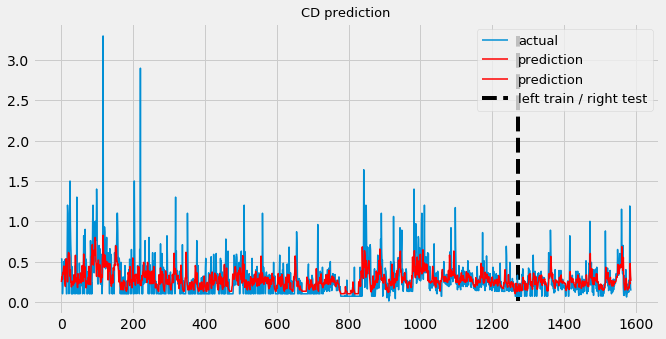

In [332]:
#train
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name
                , y_train=ts[:test_index-n_steps], pred_train=pred_train)

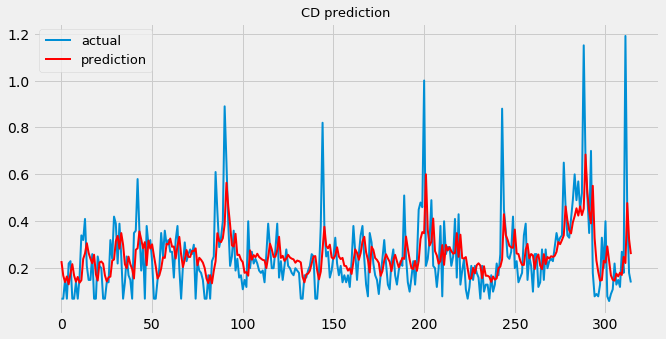

In [333]:
#test
plot_prediction(y_test=ts[test_index+n_steps:], pred_test=pred_test, target_name=target_name)